### Quadruped PID tracking of random trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
from grp import GaussianRandomPathClass,kernel_se,kernel_levse
from snapbot_util import get_snapbot_q,wait_until_snapbot_on_ground,snapbot_rollout
from util import soft_squash_multidim,get_colors,r2rpy,plot_topdown_trajectory,get_anchors_from_traj
print ("Done.")

Done.


### Initialize GRP

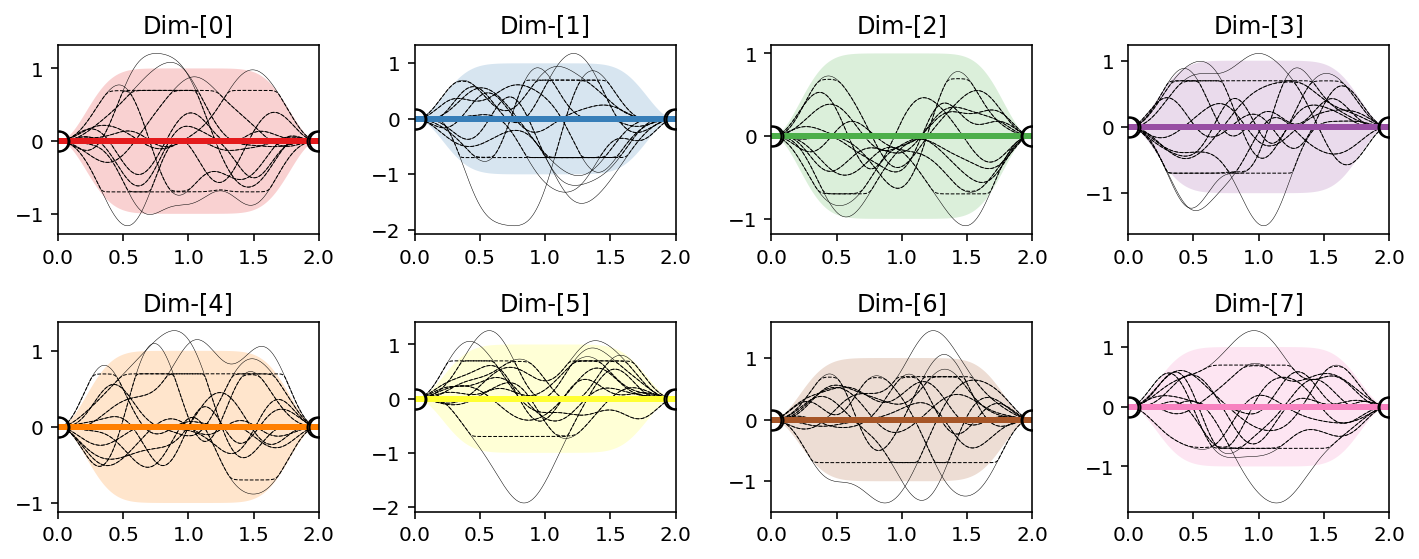

In [14]:
dur_sec = 2.0
env = MuJoCoParserClass(name='Snapbot',rel_path='../asset/snapbot/robot_4_1245.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name    = 'PID',
    k_p     = 20.0,
    k_i     = 0.1,
    k_d     = 1.0,
    dim     = env.n_torque,
    out_min = env.torque_range[:,0],
    out_max = env.torque_range[:,1])
GRP_prior = GaussianRandomPathClass(name='GRP Prior',kernel=kernel_levse)
GRP_prior.set_prior(q_init=np.zeros(env.n_torque),dur_sec=dur_sec,HZ=env.HZ,hyp={'g':1/4,'l':1/4,'w':1e-8})
GRP_prior.plot(figsize=(10,4),subplot_rc=(2,4),tfs=12,
               ss_x_min=-40*np.pi/180*np.ones(8),ss_x_max=40*np.pi/180*np.ones(8),ss_margin=5*np.pi/180)
GRP_posterior = GaussianRandomPathClass(name='GRP Posterior',kernel=kernel_levse)
ss_range  = 40*np.pi/180*np.concatenate((-np.ones((env.n_torque,1)),np.ones((env.n_torque,1))),axis=1)
ss_margin = 10*np.pi/180

### Rollout from GRP

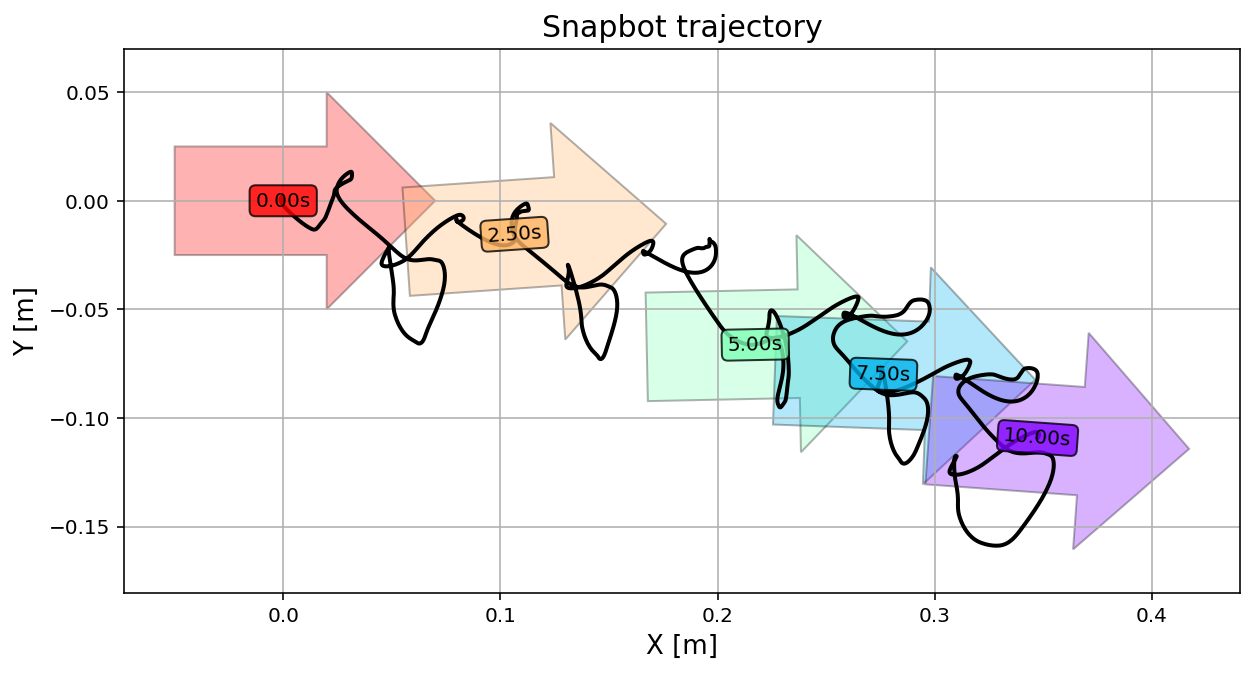

Done.


In [19]:
# Sample
traj_joints,traj_secs = GRP_prior.sample_one_traj(
    rand_type='Uniform',ss_x_min=ss_range[:,0],ss_x_max=ss_range[:,1],ss_margin=ss_margin)
# Rollout
res = snapbot_rollout(env,PID,traj_joints,n_traj_repeat=5,DO_RENDER=False)
plot_topdown_trajectory(
    res['sec_list'],res['xyrad_list'],cm=plt.cm.rainbow_r,figsize=(10,5),title_str='Snapbot trajectory')
print ("Done.")

### Rollout from the interpolated GRP

Creating window glfw


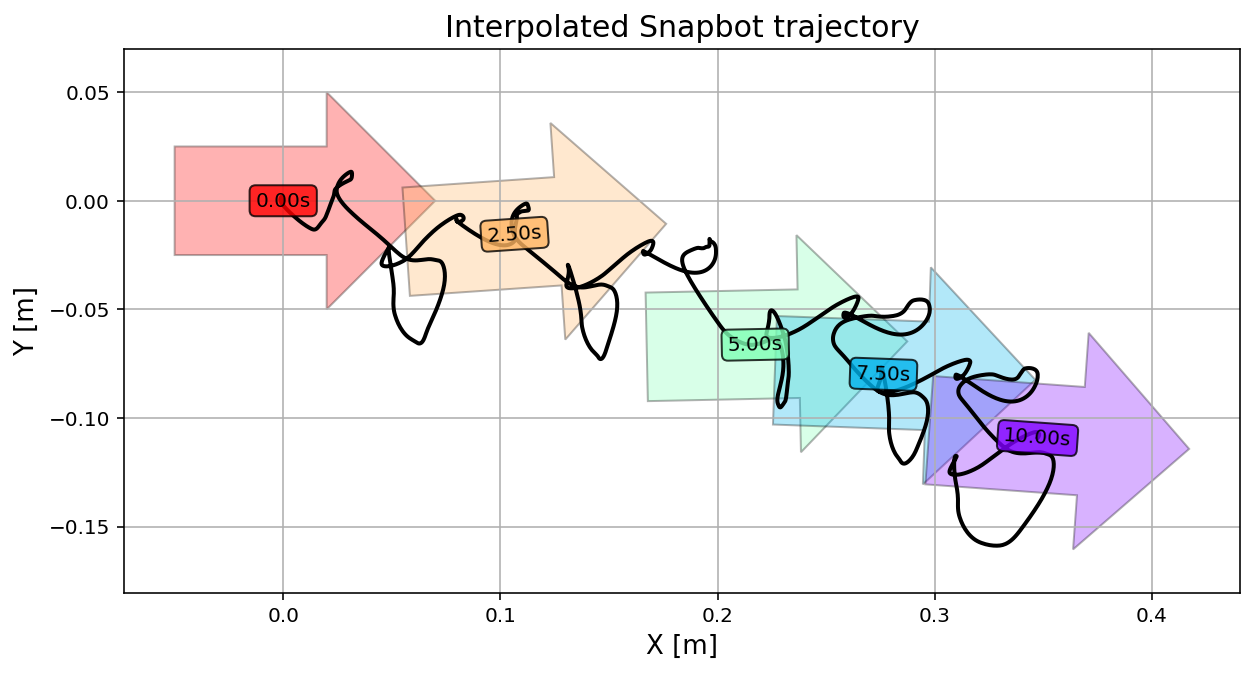

In [27]:
t_anchor,x_anchor = get_anchors_from_traj(traj_secs,traj_joints,n_anchor=20)
traj_joints_intp = GRP_posterior.interpolate(
    t_anchor=t_anchor,x_anchor=x_anchor,t_test=traj_secs,hyp={'g':1,'l':1/2,'w':1e-8},
    APPLY_EPSRU=True,t_eps=0.025, # <= this is important
    x_min=ss_range[:,0],x_max=ss_range[:,1],margin=ss_margin)
res_intp = snapbot_rollout(env,PID,traj_joints,n_traj_repeat=5,DO_RENDER=True)
plot_topdown_trajectory(
    res_intp['sec_list'],res_intp['xyrad_list'],cm=plt.cm.rainbow_r,
    figsize=(10,5),title_str='Interpolated Snapbot trajectory')

### Plot the original and interpolated joint trajectories

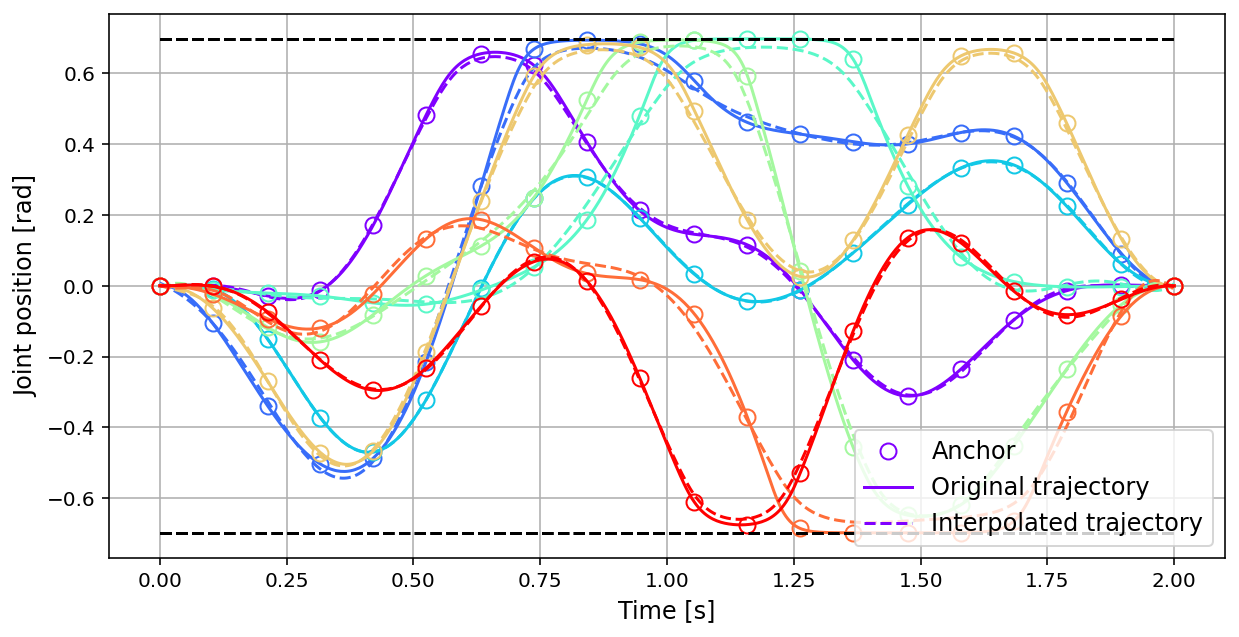

In [31]:
plt.figure(figsize=(10,5))
colors = get_colors(env.n_torque)
for i_idx in range(env.n_torque):
    color = colors[i_idx]
    if i_idx == 0:
        plt.plot(t_anchor,x_anchor[:,i_idx],'o',color=color,ms=8,mfc='none',label='Anchor')
        plt.plot(traj_secs,traj_joints[:,i_idx],'-',color=color,label='Original trajectory')
        plt.plot(traj_secs,traj_joints_intp[:,i_idx],'--',color=color,label='Interpolated trajectory')
    else:
        plt.plot(t_anchor,x_anchor[:,i_idx],'o',color=color,ms=8,mfc='none')
        plt.plot(traj_secs,traj_joints[:,i_idx],'-',color=color)
        plt.plot(traj_secs,traj_joints_intp[:,i_idx],'--',color=color)
    # Plot limit
    plt.plot([traj_secs[0],traj_secs[-1]],[ss_range[i_idx,0],ss_range[i_idx,0]],'--',color='k')
    plt.plot([traj_secs[0],traj_secs[-1]],[ss_range[i_idx,1],ss_range[i_idx,1]],'--',color='k')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time [s]',fontsize=12)
plt.ylabel('Joint position [rad]',fontsize=12)
plt.grid('on')
plt.show()